Программа получает на вход файлы из папки, в которых содержатся данные для построения графиков, отрисовывает каждый график и по надобности сохраняет его. Дополнительно увеличение по временному масштабу 100 нс, 1 мкс, 10 мкс.  
_______
**Названия рисунков**  
AAA.A_CCC_D_E_10us.png 
AAA.A – Толщина образца и порядковый номер (400.1)  
BBBBBB – День эксперимента  - день месяц год(060924)  
CCC – Номер эксперимента (001)  
D – Количество импульсов(1)  
E – Энергия в импульсе нДж (5)  
F - Увеличение(10us)  
____
**Пример** получившегося названия:  
400.1.060924.001.1.5.png

#### Задачи:
- Название файлов
- Перевод в Вт
- Обрабатывать новые файлы в режиме реального времени
- Inf/Nan - исправить

In [ ]:
!pip install pandas matplotlib openpyxl scipy

Tek090_ALL.csv


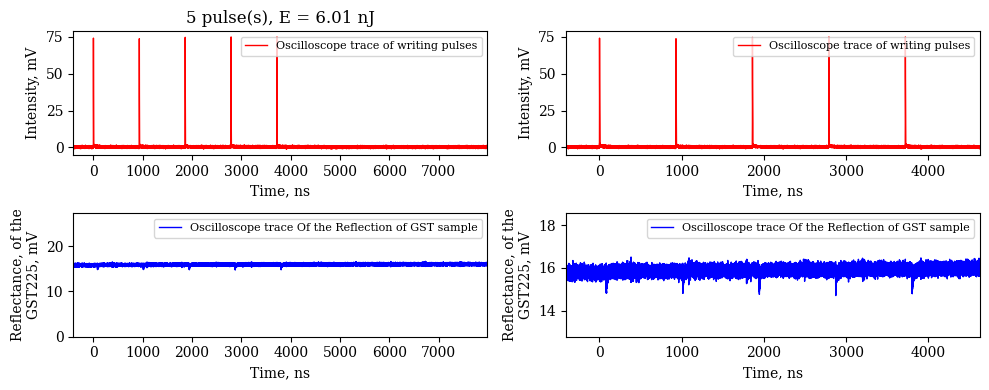

Tek123_ALL.csv


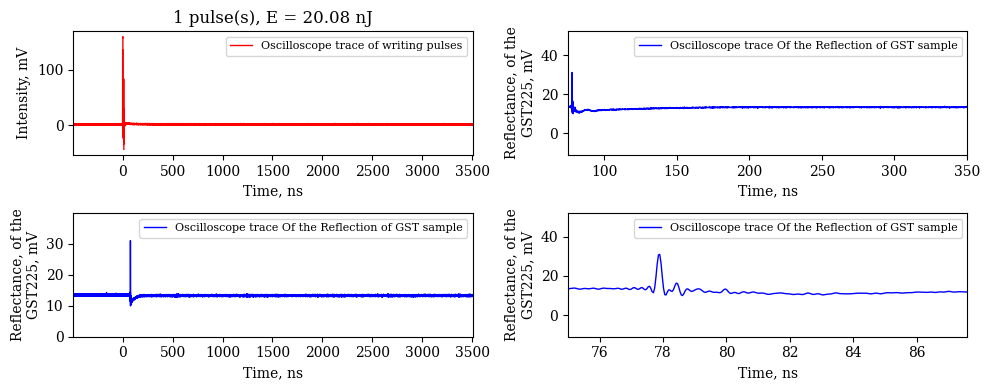

shot11.csv


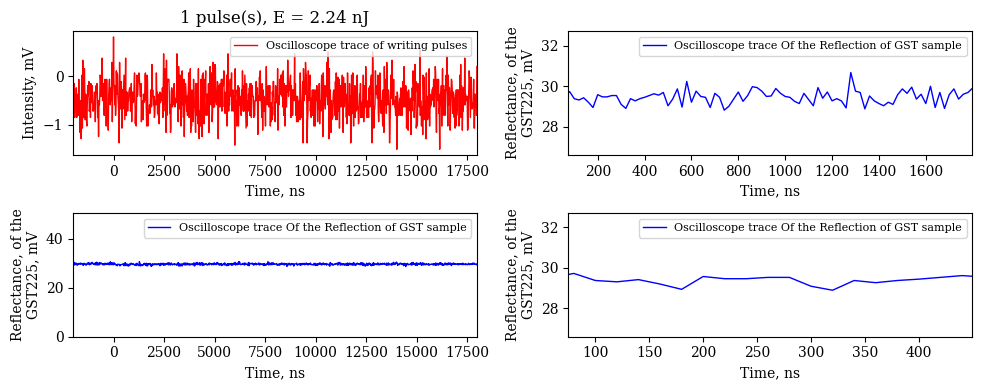

shot12.csv


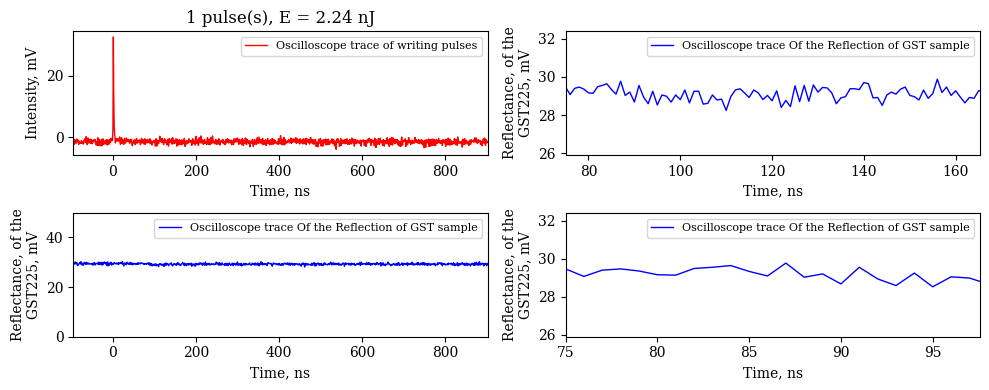

shot13.csv


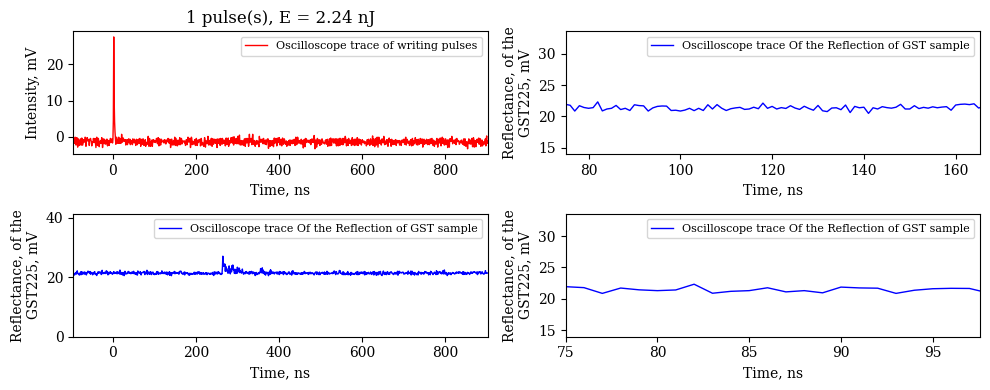

shot14.csv


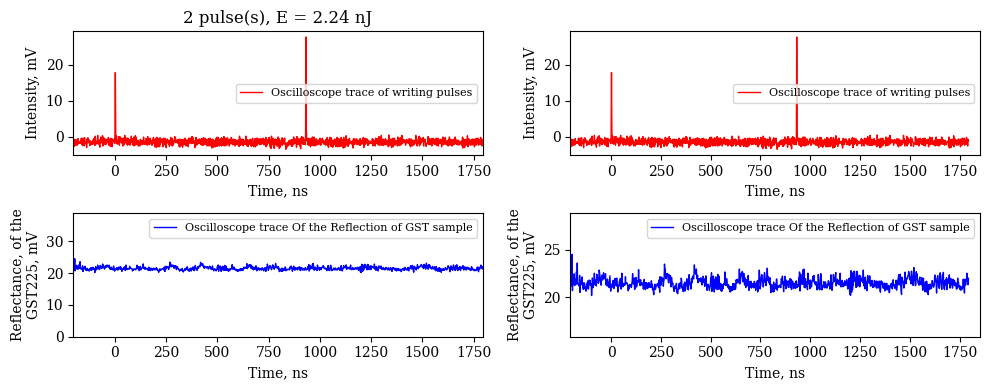

shot15.csv


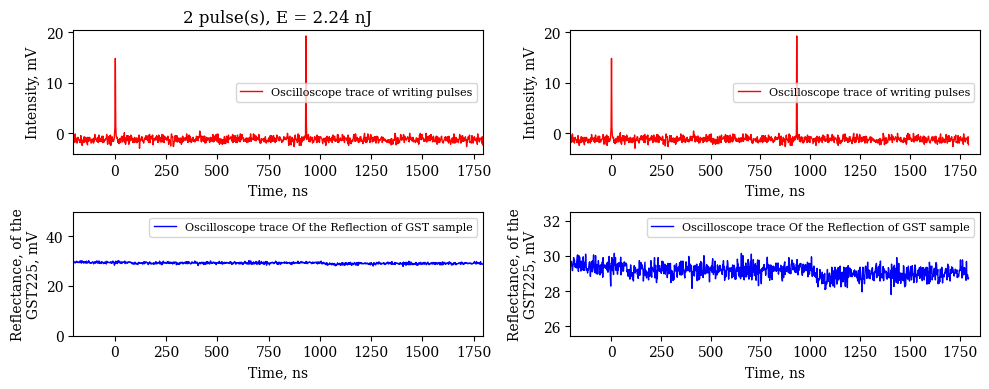

shot16.csv


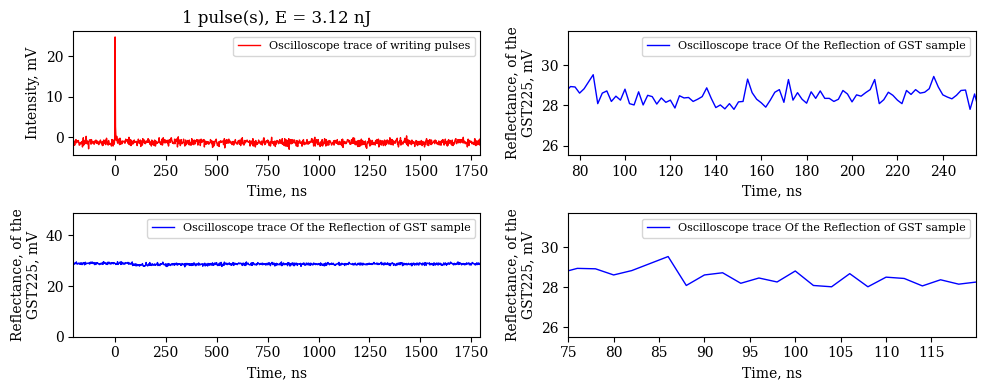

shot17.csv


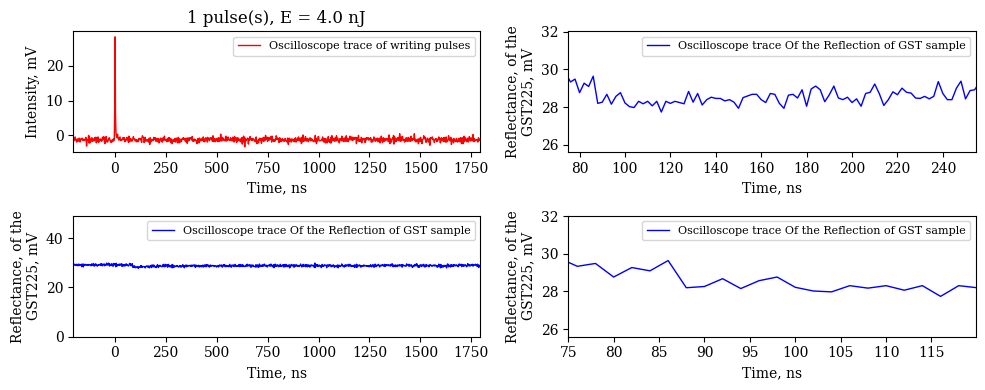

shot18.csv


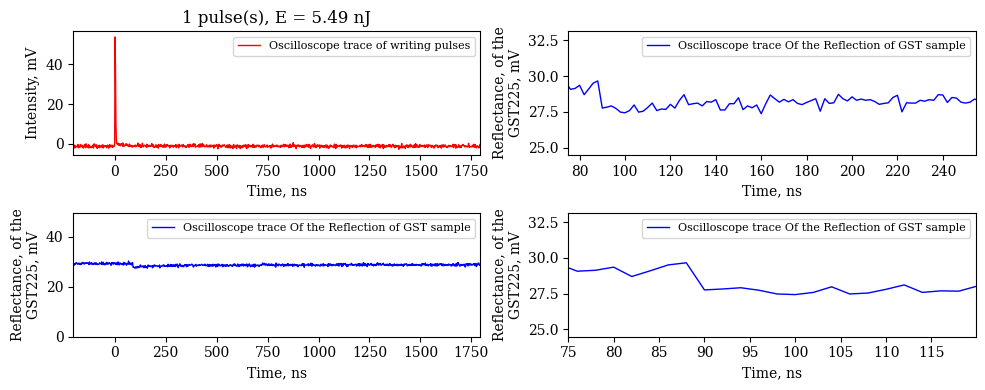

shot19.csv


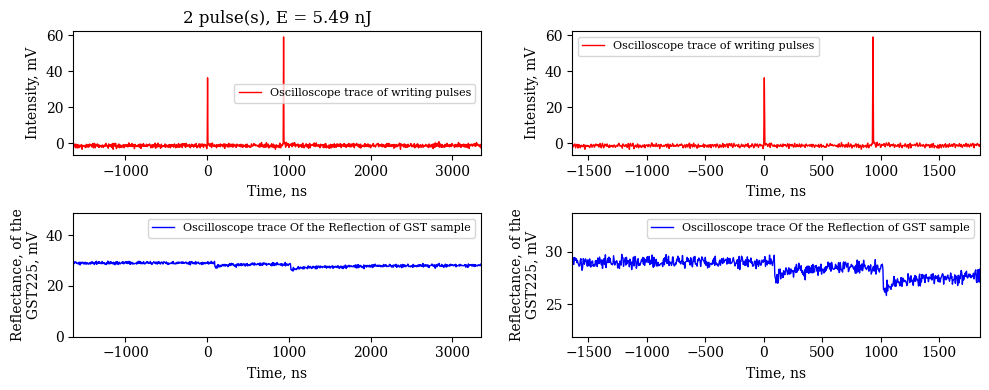

shot20.csv


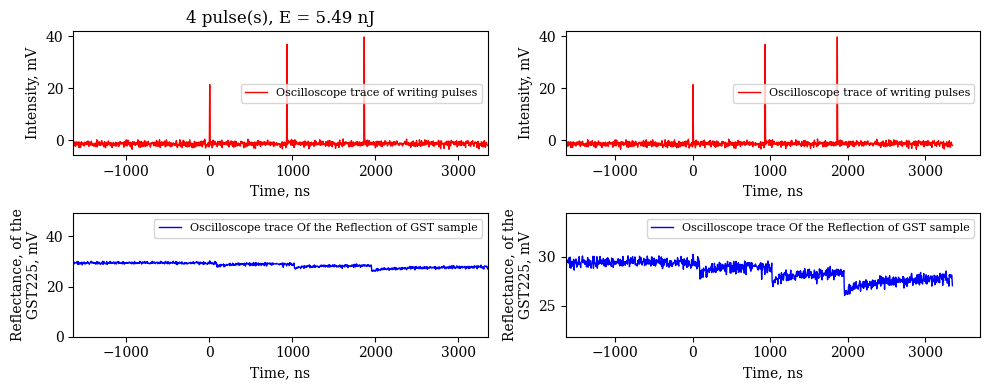

shot21.csv


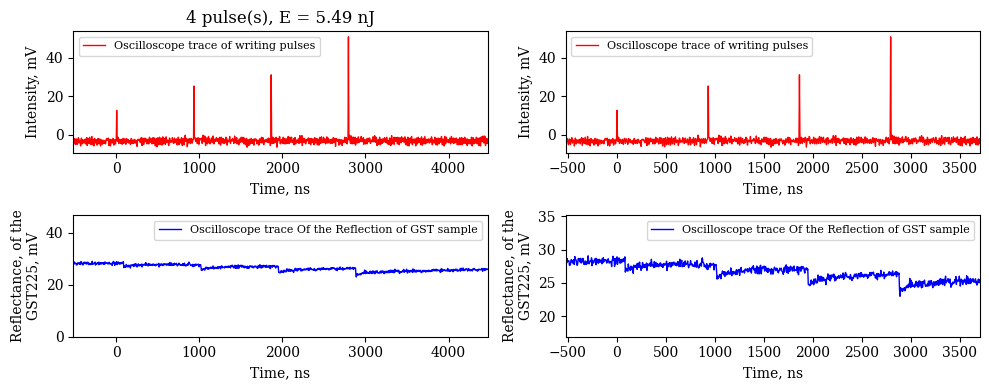

shot22.csv


KeyboardInterrupt: 

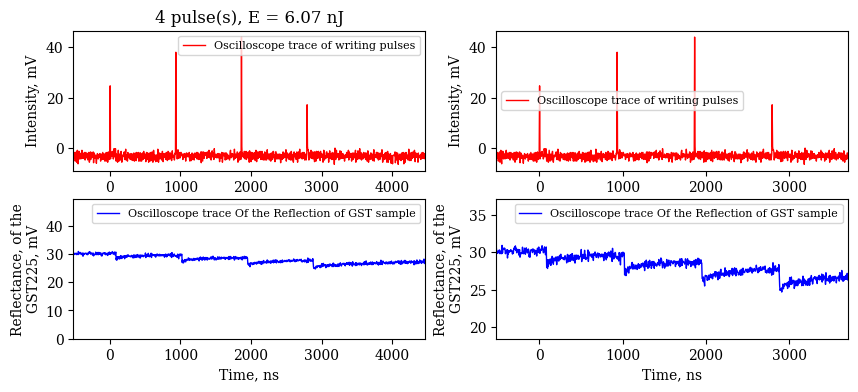

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
import numpy as np
from scipy.signal import find_peaks 

start_file = None
# start_file = 'shot18.csv' # Rigol
# start_file = 'Tek012.csv' # Tektronix

# dir = 'waveforms/110924/' # папка с осциллограммами
dir = 'waveforms/060924/Осциллограммы переходов/' # папка с осциллограммами
general_file = 'waveforms/060924/General.xlsx'
files = sorted(os.listdir(dir))

csv_files_all = [file for file in files if (file.endswith('.csv'))]
csv_files = [file for file in csv_files_all if (file.startswith('shot') or file.startswith('Tek'))]

df_gen = pd.read_excel(general_file)
col_index = df_gen.columns.get_loc('Общая энергия, нДж')
df_gen = df_gen.iloc[:, :col_index+1]

def plot_graph(x, y, color_, label_, ylabel, xlabel, xlim1, xlim2, increase, x2_supplement):
    plt.xlim(xlim1, xlim2/increase + x2_supplement)
    plt.ylabel(ylabel, fontsize=10)
    plt.xlabel(xlabel, fontsize=10)
    plt.plot(df[x]*1e9, df[y]*1e3, color=color_, linewidth=1,
             label=label_)
    plt.legend(fontsize=8)


def plot_graphics(pulses, energy, flag_pulse, peak, x2_supplement):
    plt.figure(figsize=(10, 4))
    plt.rcParams["font.family"] = "serif" # font

    # 1) Без увеличения
    plt.subplot(2, 2, 1)
    plot_graph(x='TIME', y='CH1', color_='red', 
        label_='Oscilloscope trace of writing pulses', 
        ylabel='Intensity, mV', xlabel='Time, ns', 
        xlim1=df.iloc[0, 0]*1e9, xlim2=df.iloc[-1, 0]*1e9, increase=1, x2_supplement=0)
    plt.title(label= f'{pulses} pulse(s), E = {energy} nJ')


    plt.subplot(2, 2, 3)
    plot_graph(x='TIME', y='CH2', color_='blue', 
        label_='Oscilloscope trace Of the Reflection of GST sample', 
        ylabel=r'Reflectance, of the' + '\n' +'GST225, mV', xlabel='Time, ns', 
        xlim1=df.iloc[0, 0]*1e9, xlim2=df.iloc[-1, 0]*1e9, increase=1, x2_supplement=0)
    plt.ylim(0, (df['CH2'].max() + y_avg*2/3 )*1e3)
    

    # 2) Увеличение
    plt.subplot(2, 2, 2)
    if (flag_pulse=='one'):
        plot_graph(x='TIME', y='CH2', color_='blue', 
            label_='Oscilloscope trace Of the Reflection of GST sample', 
            ylabel=r'Reflectance, of the' + '\n' +'GST225, mV', xlabel='Time, ns', 
            xlim1=75, xlim2=(df.iloc[-1, 0]*1e9), increase=10, x2_supplement=x2_supplement)
        plt.ylim(y_start*1e3, y_end*1e3)
        
    else:
        plot_graph(x='TIME', y='CH1', color_='red', 
            label_='Oscilloscope trace of writing pulses', 
            ylabel='Intensity, mV', xlabel='Time, ns', 
            xlim1=df.iloc[0, 0]*1e9, xlim2=df.iloc[peak, 0]*1e9+926, increase=1, x2_supplement=0)


    # 3) Увеливение
    plt.subplot(2, 2, 4)
    if (flag_pulse=='one'):
        xlim1_ = 75
        xlim2_ = df.iloc[-1, 0]*1e9
        increase_ = 40
        x2_supp = x2_supplement
    else:
        xlim1_ = df.iloc[0, 0]*1e9
        xlim2_ = df.iloc[peak, 0]*1e9+926
        increase_ = 1
        x2_supp = 0

    plot_graph(x='TIME', y='CH2', color_='blue', 
        label_='Oscilloscope trace Of the Reflection of GST sample', 
        ylabel=r'Reflectance, of the' + '\n' +'GST225, mV', xlabel='Time, ns', 
        xlim1=xlim1_, xlim2=xlim2_, increase=increase_, x2_supplement=x2_supp)
    plt.ylim(y_start*1e3, y_end*1e3)


    plt.tight_layout()  # Автоматическая регулировка расстояния между графиками
    

# Узнаем номер снимка
def osc_number(file):
    if ('Tek' in file):
        exp_number = file.replace('Tek', '')
        exp_number = exp_number.replace('.csv', '')
        exp_number = exp_number.replace('_ALL', '')
    else:
        exp_number = file.replace('shot', '')
        exp_number = exp_number.replace('.csv', '')

    return int(exp_number)


def last_peak(df, pulses):
    time = 926 *1e-9 * (pulses - 1)
    idx_nearest_time =  (df['TIME'] - time).abs().idxmin()
    return idx_nearest_time


start_index = csv_files.index(start_file) if start_file is not None else 0
for file in csv_files[start_index:]:
    path = dir + file

    # Для пропуска любой "Шапки" файла
    f = open(path, 'r')
    lines = f.readlines()
    skip_lines = next(i for i, line in enumerate(lines) 
                  if 'TIME' in line or 'Time(s)' in line)
    f.close()

    # Номер эксперимента, кол-во импульсов, энергия
    num = osc_number(file)
    pulses = df_gen.loc[df_gen['Shot'] == num, 'Количество'].iloc[0]
    energy = round(df_gen.loc[df_gen['Shot'] == num, 
                              'Энергия, нДж'].iloc[0], 2)
    
    flag_pulse = 'many' if pulses > 1 else 'one' 
    

    column_names = ['TIME', 'CH1', 'CH2', 'CH3']
    df = pd.read_csv(path, skiprows=skip_lines+1, header=None, names=column_names)
    df = df.drop('CH3', axis=1)
    df.replace(np.inf, np.nan, inplace=True) # Если есть значения Inf
    df.replace(-np.inf, 0.000000001212, inplace=True)

    diff = df['CH2'].max()-df['CH2'].min()
    y_start = df['CH2'].min() - diff
    y_end = df['CH2'].max() + diff
    y_avg = df['CH2'].mean()

    x2_supplement = 0 if (df.iloc[-1, 0]*1e9 / 40 > 75) else 75

    df.replace(np.nan, np.inf, inplace=True) # Если есть значения Inf
    df.replace(0.000000001212, -np.inf, inplace=True)

    if (flag_pulse == 'many'):
        peak = last_peak(df, pulses)
    

    print(file)
    plot_graphics(pulses, energy, flag_pulse, peak, x2_supplement)
    plt.show()
    
    
    # save = input('Save?(y or n): ')
    # if(save == 'y'): 
    #     plot_graphics(pulses, energy)
    #     plt.savefig('013.png', dpi=300, bbox_inches='tight')

    # plt.close()

    